<h1>Model 0<h1>

# import libraries and make customer cluster nodes
## Start of Model 0


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
import igraph as ig
import geopy.distance
import folium
from math import radians, cos, sin, asin, sqrt
import networkx as nx
from geopy.distance import geodesic
from itertools import product
# Load your dataset and remove NA values
customer_orders_points_07052024 = pd.read_csv("C:/Users/michi/Documents/Blok 2 Jaar 4/Customer_orders_points_07052024.csv")
customer_id = customer_orders_points_07052024['POSTCODE'].dropna()
order_quantity = customer_orders_points_07052024['Quantity_Delivered'].dropna()
latitude = customer_orders_points_07052024['y'].dropna()
latitude = latitude[(latitude <= 90) & (latitude >= -90)]
longitude = customer_orders_points_07052024['x'].dropna()
longitude = longitude[(longitude <= 90) & (longitude >= -90)]
min_length = min(len(longitude), len(latitude))  # min(len(longitude), len(latitude)) or any other criteria
# Standardize all vector lengths
customer_id = customer_id.head(min_length)
order_quantity = order_quantity.head(min_length)
latitude = latitude.head(min_length)
longitude = longitude.head(min_length)
# Create DataFrame from customer order data
customer_data = pd.DataFrame({
    'Customer': customer_id,
    'Latitude': latitude,
    'Longitude': longitude,
    'Order_quantity': order_quantity
})
# Create grouped dataset
grouped_data = customer_data.groupby(['Latitude', 'Longitude', 'Order_quantity']).agg(Num_Customers=('Customer', 'nunique')).reset_index()
# Combine orders per location
combined_orders = grouped_data.groupby(['Latitude', 'Longitude']).agg(
    Total_Order_Quantity=('Order_quantity', 'sum'),
    Total_Num_Customers=('Num_Customers', 'sum')
).reset_index()
# Perform clustering using DBSCAN on combined_orders dataset based on geoposition only
eps = 0.62  # Adjust epsilon (neighborhood distance) as needed
minPts = 39  # Adjust minPts (minimum number of points in a cluster) as needed
dbscan = DBSCAN(eps=eps, min_samples=minPts, metric='euclidean')
dbscan_result = dbscan.fit_predict(combined_orders[['Longitude', 'Latitude']])
# Assign cluster labels to data points
combined_orders['Cluster'] = dbscan_result
# Calculate cluster centers
cluster_centers_df = combined_orders.groupby('Cluster').agg(
    Longitude=('Longitude', 'mean'),
    Latitude=('Latitude', 'mean'),
    Total_Order_Quantity=('Total_Order_Quantity', 'sum'),
    Count=('Latitude', 'size')
).reset_index()
cluster_centers_df['ID'] = ['Cluster_' + str(i + 1) for i in range(len(cluster_centers_df))]
customer_nodes = cluster_centers_df[['ID', 'Total_Order_Quantity', 'Latitude', 'Longitude']]
# Create a dataframe
df = pd.DataFrame({
    'ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Country': ["Portugal", "Spain", "Italy", "France", "Belgium", "Latvia", "Poland", "Portugal", "Slovenia", "Spain", "Turkey", "Belgium"],
    'City': ["Lissabon", "Alovera", "Cologno Monzese", "Blyes", "Turnhout", "Dobele", "Pionki", "Lissabon", "Srpenica", "Alovera", "Tuzla, Istanbul", "Pelt"],
    'Plant_type': ["Receiving plant", "Receiving plant", "Receiving plant", "Receiving plant", "Producing plant", "Producing plant", "Producing plant", "Producing plant", "Producing plant", "Producing plant", "Producing plant", "Producing plant"],
    'ZIP_code': ["2710-207", "19208", "20093", "1150", "2300", "3701", "26-670", "2710-207", "5224", "19208", "34956", "3900"],
    'Receiving_plant': [2200, 1900, 2000, 1800, None, None, None, None, None, None, None, None],
    'X_coordinate': [-9.369216, -3.243162431, 9.281575673, 5.261173337, 4.928540898, 23.30237845, 21.45811508, -9.369216, 13.5166732, -3.243162431, 29.36691489, 5.3966],
    'Y_coordinate': [38.757301, 40.57675934, 45.54113003, 45.83747369, 51.29525785, 56.62518423, 51.46902482, 38.757301, 46.28409136, 40.57675934, 40.8858807, 51.1913],
    'Geometry': ["POINT (-9.36922 38.75730)", "POINT (-3.24316 40.57676)", "POINT (9.28158 45.54113)", "POINT (5.26117 45.83747)", "POINT (4.92854 51.29526)", "POINT (23.30238 56.62518)", "POINT (21.45812 51.46902)", "POINT (-9.36922 38.75730)", "POINT (13.51667 46.28409)", "POINT (-3.24316 40.57676)", "POINT (29.36691 40.88588)", "POINT (5.3966,51.1913)"]
})

C:\Users\michi\miniconda3\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\michi\AppData\Local\Temp\ipykernel_15436\1037016153.py:14: DtypeWarning: Columns (6,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  customer_orders_points_07052024 = pd.read_csv("C:/Users/michi/Documents/Blok 2 Jaar 4/Customer_orders_points_07052024.csv")


# Make warehouse nodes

In [2]:
# Load in the interplant orders
Interplant_Orders_2023_2 = pd.read_csv("C:/Users/michi/Documents/Blok 2 Jaar 4/Interplant_Orders_2023_2.csv")
# Assign an easier name to the variable
Order_Ref = Interplant_Orders_2023_2
# Split the aggregated data into producing plants and receiving plants
producing_plants = df[df['Plant_type'] == "Producing plant"]
receiving_plants = df[df['Plant_type'] == "Receiving plant"]
# Create a new dataframe with the desired structure
new_df = pd.DataFrame({
    'ID': df['City'] + " plant " + df['ID'].astype(str),
    'Total_Quantity': df['Receiving_plant'],
    'Latitude': df['Y_coordinate'],
    'Longitude': df['X_coordinate']
})
# Convert Total_Quantity to integer
new_df['Total_Quantity'] = new_df['Total_Quantity'].astype(pd.Int64Dtype())
# # Group the data by warehouse and calculate both total capacity and frequency
# warehouse_capacity = Order_Ref.groupby('Producing_Plant').agg(
#     Total_Capacity=('Quantity_Delivered', 'sum'),
#     Frequency=('Producing_Plant', 'count')
# ).reset_index()
# # Create a lookup table mapping country names to country codes
# country_lookup_producing = pd.DataFrame({
#     'Country': ["Belgium", "Latvia", "Poland", "Portugal", "Slovenia", "Spain", "Turkey"],
#     'Country_Code': ["BE", "LV", "PL", "PT", "SI", "ES", "TR"]
# })
# # Create a lookup table mapping country names to country codes
# country_lookup_receiving = pd.DataFrame({
#     'Country': ["Lissabon", "Alovera", "Cologno Monzese", "Byles"],
#     'Country_Code': ["PT", "ES", "IT", "FR"]
# })
# # Replace the country names with country codes in the producing dataframe
# producing_plants['Country'] = producing_plants['Country'].map(dict(zip(country_lookup_producing['Country'], country_lookup_producing['Country_Code'])))
# # Replace the country names with country codes in the receiving dataframe
# receiving_plants['Country'] = ["PT", "ES", "IT", "FR"]
# # Grouping by Producing_Plant and Receiving_Plant, and summarizing the Quantity_Delivered and Order_Ref
# flow_data = Order_Ref.groupby(['Producing_Plant', 'Receiving_Plant']).agg(
#     Total_Quantity=('Quantity_Delivered', 'sum'),
#     Frequency=('Producing_Plant', 'count')
# ).reset_index()
# # Arranging the data by frequency in descending order
# flow_data = flow_data.sort_values(by=['Producing_Plant'])
# # Assigning country codes and coordinates
# flow_data['Country'] = ["BE", "PL", "GB", "BE", "BE", "NL", "DE", "PL", "TR", "SI", "PL", "BE", "NL"]
# flow_data['X_coordinate'] = [51.3377, 52.3753, 52.6043, 51.1913, 51.1055, 51.2518, 51.0625, 51.4583, 40.6295, 46.2914, 51.4583, 51.1055, 51.5064]
# flow_data['Y_coordinate'] = [4.9345, 20.6860, 1.6485, 5.3966, 3.8589, 5.6885, 6.9419, 21.4481, 30.6428, 13.4568, 21.4481, 3.8589, 4.2572]
# flow_data.columns = ["Producing_Plant", "Receiving_Plant", "Total Quantity", "Frequency", "Country", "Latitude", "Longitude"]
# # Assigning IDs
# flow_data['ID'] = ["Turnhout plant 1000", "Dąbrówka plant 1030", "Great_Britain plant 1100", "Pelt plant 1400", "Gent plant 1500",
#                    "Weert plant 1600", "Leverkussen plant 1700", "Pionki plant 2400", "Turkey Plant 5200", "Srpenica plant 5600",
#                    "Pionki plant 5900", "Gent plant 6700", "Bergen_op_zoom plant 8700"]
# # Selecting specific columns
# logistical_flow_nodes = flow_data[['ID', 'Total Quantity', 'Latitude', 'Longitude']]
logistical_nodes = new_df[['ID', 'Latitude', 'Longitude']]
# Given plant dataset
plant_dataset = logistical_nodes
# Given customer dataset
customer_dataset = pd.DataFrame({
    'ID': cluster_centers_df['ID'],
    'Longitude': cluster_centers_df['Longitude'],
    'Latitude': cluster_centers_df['Latitude']
})

# Create combined dataset and specify which nodes to feature in the algorithm

In [3]:
# Create the final combined dataset
combined_dataset = pd.concat([new_df[['ID', 'Latitude', 'Longitude']], cluster_centers_df[['ID', 'Latitude', 'Longitude']]], ignore_index=True)
 
# Adjust index to start from 1
combined_dataset.index = combined_dataset.index
 
# Calculate distances between each pair of points
def calculate_distance(point1, point2):
    return geodesic(point1, point2).kilometers
 
distances = np.zeros((len(combined_dataset), len(combined_dataset)))
 
for i, j in product(range(len(combined_dataset)), repeat=2):
    distances[i, j] = calculate_distance(
        (combined_dataset['Latitude'].iloc[i], combined_dataset['Longitude'].iloc[i]),
        (combined_dataset['Latitude'].iloc[j], combined_dataset['Longitude'].iloc[j])
    )
 
# Create a graph from the distance matrix
g = nx.from_numpy_array(distances, create_using=nx.Graph)
 
def create_map(combined_dataset):
    # Create a folium map centered around the average latitude and longitude
    avg_lat = combined_dataset['Latitude'].mean()
    avg_lon = combined_dataset['Longitude'].mean()
    folium_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=5)
 
    # Add markers to the map
    for _, row in combined_dataset.iterrows():
        if 'Cluster' in row['ID']:
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup=f"Cluster: {row['ID']}",
                icon=folium.Icon(color='blue'),
                tooltip=row['ID']
            ).add_to(folium_map)
        else:
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup=f"Warehouse: {row['ID']}",
                icon=folium.Icon(color='red'),
                tooltip=row['ID']
            ).add_to(folium_map)
    # Add legend
    legend_html = """
<div style="position: fixed; bottom: 50px; right: 50px; z-index:9999; background-color:white; border:2px solid grey; padding: 10px;">
<h4>Legend</h4>
<p><span style="color:blue">&#9632;</span> Customer Clusters</p>
<p><span style="color:red">&#9632;</span> Warehouses</p>
</div>
    """
    folium_map.get_root().html.add_child(folium.Element(legend_html))
 
    # Display the map
    display(folium_map)
 
# Display the map
create_map(combined_dataset)
 
# Function to select specified nodes manually
def select_nodes():
    selected_nodes = input("Enter the row numbers of the nodes you want to include, separated by commas: ")
    selected_nodes = list(map(int, selected_nodes.split(',')))
    return selected_nodes
 
# Display the map before selecting nodes
display(combined_dataset)
 
# Specify nodes for the objective function
specified_nodes = select_nodes()  # The script stops here and waits for user input

,ID,Latitude,Longitude
0,Lissabon plant 1,38.757301,-9.369216
1,Alovera plant 2,40.576759,-3.243162
2,Cologno Monzese plant 3,45.541130,9.281576
3,Blyes plant 4,45.837474,5.261173
4,Turnhout plant 5,51.295258,4.928541
5,Dobele plant 6,56.625184,23.302378
6,Pionki plant 7,51.469025,21.458115
7,Lissabon plant 8,38.757301,-9.369216
8,Srpenica plant 9,46.284091,13.516673
9,Alovera plant 10,40.576759,-3.243162


Enter the row numbers of the nodes you want to include, separated by commas: 0,1,2,3,4,8,11


# Define Dijsktra's search objective and execute the algorithm
## Following will be outputted a new coordinate alongside a visual map

In [4]:
def objective_function_dijkstra(coords, specified_nodes, combined_dataset, g):
    # Determine the index for the new node
    new_node_index = len(combined_dataset)
    # Create a temporary graph to add the new node and edges
    temp_graph = g.copy()
    temp_graph.add_node(new_node_index)
    # Calculate the total distance from the new warehouse to each specified node
    total_distance = 0
    for i in specified_nodes:
        distance = calculate_distance(
            (coords['Latitude'], coords['Longitude']),
            (combined_dataset['Latitude'].iloc[i], combined_dataset['Longitude'].iloc[i])
        )
        total_distance += distance
    return total_distance
 
# Define grid search ranges
lon_range = np.linspace(combined_dataset['Longitude'].min(), combined_dataset['Longitude'].max(), num=100)
lat_range = np.linspace(combined_dataset['Latitude'].min(), combined_dataset['Latitude'].max(), num=100)
 
grid_search = pd.DataFrame(list(product(lon_range, lat_range)), columns=['Longitude', 'Latitude'])
 
# Calculate objective function values for each grid point
objective_values = grid_search.apply(lambda row: objective_function_dijkstra(row, specified_nodes, combined_dataset, g), axis=1)
 
# Find the coordinates of the new position that minimize the objective function
optimal_index = np.argmin(objective_values)
optimal_coords = grid_search.iloc[optimal_index]
 
# Coordinates of the new position that minimize the total distance
new_position_longitude = optimal_coords['Longitude']
new_position_latitude = optimal_coords['Latitude']
 
# Sample data
# customers = customer_nodes
# warehouses = logistical_nodes
 
new_warehouse = pd.DataFrame({
    'ID': ['New warehouse'],
    'Latitude': [new_position_latitude],
    'Longitude': [new_position_longitude]
})
# Create a folium map
m = folium.Map(location=[new_position_latitude, new_position_longitude], zoom_start=10)

# Add circle markers for customers
for idx, row in customer_dataset.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=5, color='blue', fill=True, fill_color='blue', fill_opacity=0.6, tooltip=row['ID']).add_to(m)

# Add circle markers for existing warehouses
for idx, row in plant_dataset.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=5, color='red', fill=True, fill_color='red', fill_opacity=0.6, tooltip=row['ID']).add_to(m)

# Add circle marker for new warehouse
folium.CircleMarker(location=[new_position_latitude, new_position_longitude], radius=5, color='green', fill=True, fill_color='green', fill_opacity=0.6, tooltip='New Warehouse').add_to(m)

# Define legend HTML
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 160px; height: 225px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
                 ">
     <h4 style="text-align:center">Legend</h4>
     <p><i class="fa fa-circle" style="color:blue"></i> Central Customer Clusters</p>
     <p><i class="fa fa-circle" style="color:red"></i> Existing Soudal Plants</p>
     <p><i class="fa fa-circle" style="color:green"></i> Search area for new location</p>
      </div>
     '''

# Add legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

<h1>Model I<h1>

<h3>Loading all raster files and converting them to masked arrays</h3>
<blockquote>It's necessary to convert each raster to a masked array in sum and apply custom weights to each criterion. This is done by defining a function which loads each raster and converts the layer. The masked arrays are then returned, which are assigned to a variable named 'masked_arrays'.</blockquote>

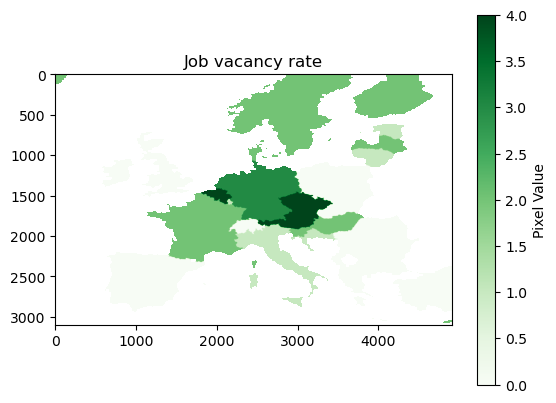

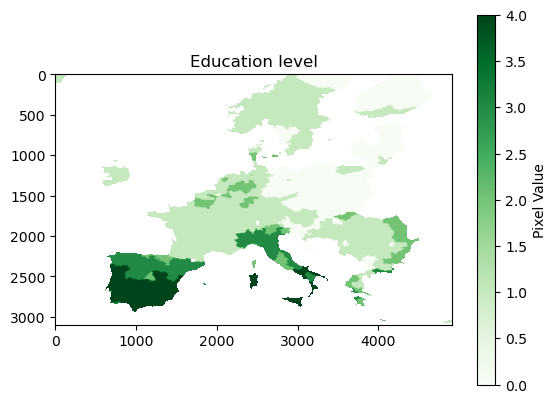

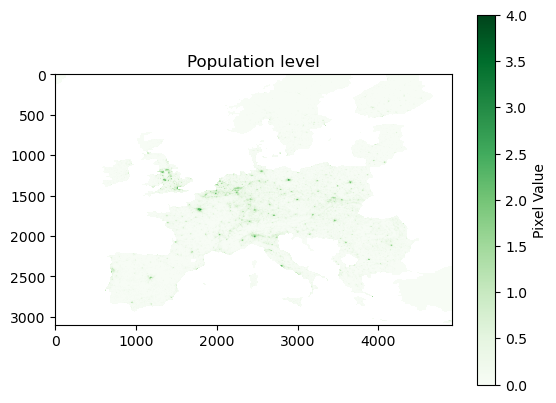

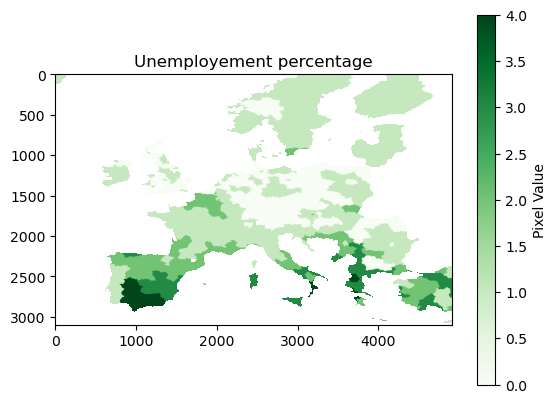

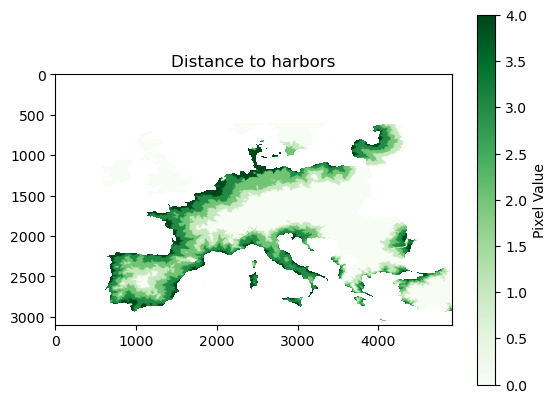

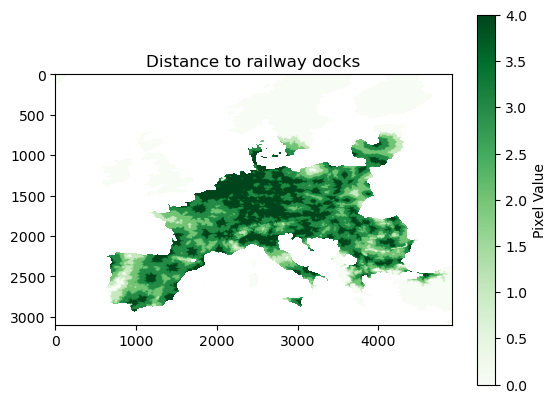

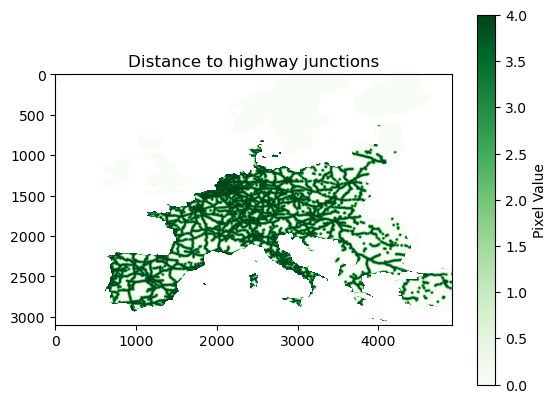

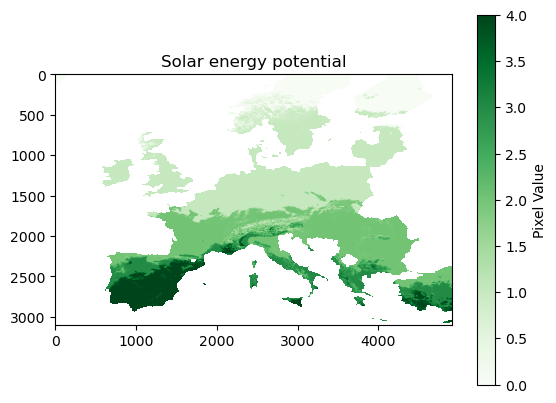

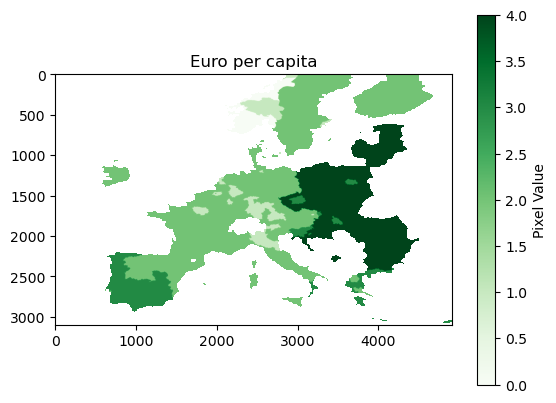

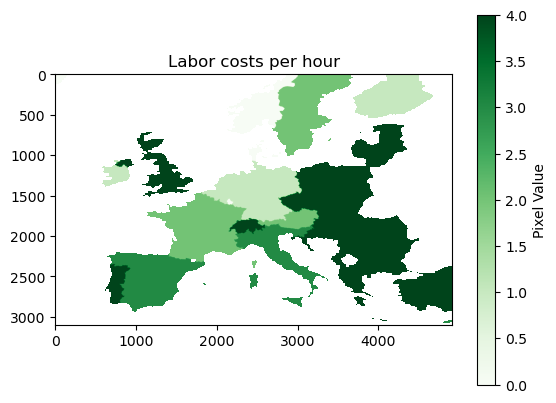

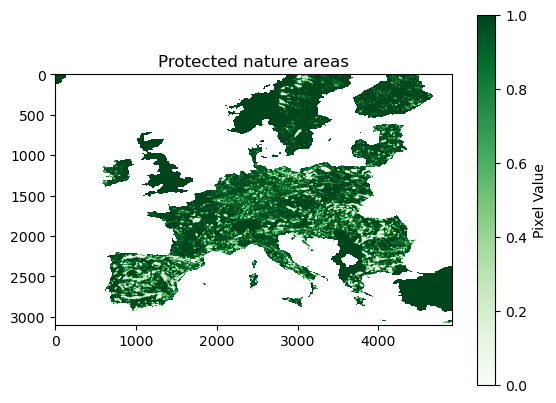

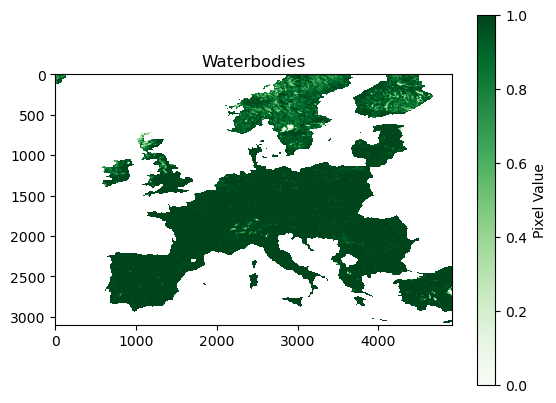

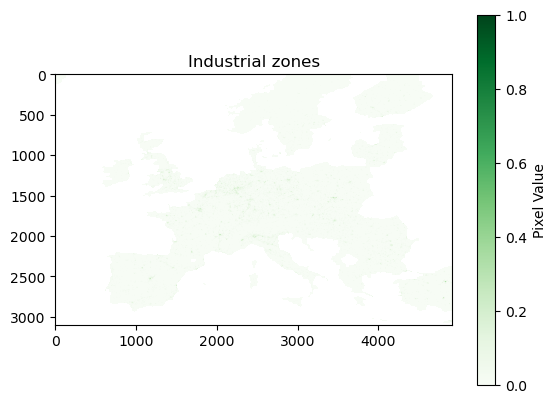

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

fp_job_vacancy = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Job_vacancy_align2.tif'
fp_education_level = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Education_align.tif'
fp_population = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Population_align4.tif'
fp_unemployement = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/unemployment_align.tif'
fp_harbors =  'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Harbour_distance_align.tif'
fp_railways = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/railway_dock_distance_align.tif'
fp_highways = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/highway_junction_distance_align.tif'
fp_solar_energy = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/solar_energy_align.tif'
fp_euro_percapita = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Labour_cost_align.tif'
fp_laborcosts_ph = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/labour_cost_hour_align4.tif'
fp_protected_nature = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Protected_nature_align.tif'
fp_waterbodies = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Waterbodies_align.tif'
fp_industrialzones = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/Industrial_zones_align.tif'


raster_fps = [fp_job_vacancy, fp_education_level, fp_population, fp_unemployement, fp_harbors, fp_railways, fp_highways, fp_solar_energy, fp_euro_percapita, fp_laborcosts_ph, fp_protected_nature, fp_waterbodies, fp_industrialzones]
plot_titles = ['Job vacancy rate',  'Education level', 'Population level', 'Unemployement percentage', 'Distance to harbors', 'Distance to railway docks', 'Distance to highway junctions', 'Solar energy potential', 'Euro per capita', 'Labor costs per hour', 'Protected nature areas', 'Waterbodies', 'Industrial zones']
def rasterizeandplot():
    masked_arrays = []
    for rasters_fp, title in zip(raster_fps, plot_titles):
        with rasterio.open(rasters_fp) as src:
            raster_data = src.read(1)
            nodata = -3.40282347e+38

            mask = np.isclose(raster_data, nodata)
            raster_data_masked = np.ma.masked_array(raster_data, mask)
            
            plt.imshow(raster_data_masked, cmap='Greens')
            plt.colorbar(label='Pixel Value')
            plt.title(title)
            plt.show()
            
            masked_arrays.append(raster_data_masked)
    
    return masked_arrays

masked_arrays = rasterizeandplot()

<h3>Merging and applying custom weights to the criterion</h3>
<blockquote>Each criterion gets their own weight based on relative importance. These weights are multiplied by the existing classification values (0-4). Next the values are multiplied by the protected nature reserves and water bodies. These were classified 0 (unsuitable) or 1 (suitable). Finally an output file is created, and the metadata from a previous raster is copied in order to transfer information and save the file.  </blockquote>

C:\Users\michi\miniconda3\lib\site-packages\numpy\ma\core.py:1013: RuntimeWarning: overflow encountered in add
  result = self.f(da, db, *args, **kwargs)
C:\Users\michi\miniconda3\lib\site-packages\numpy\ma\core.py:1013: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


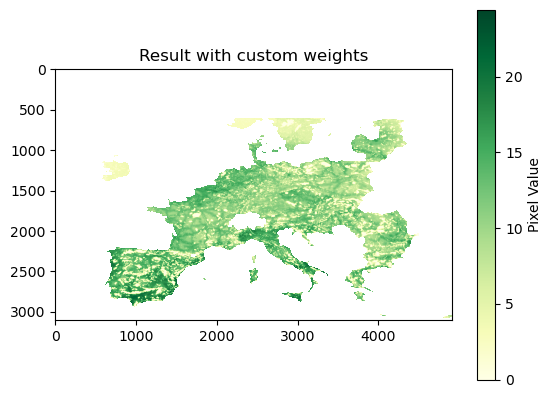

In [6]:
import pandas as pd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg

            # Job vacancy rate 
merge = ((masked_arrays[0] * 0.6) +   
            # Education level         
             (masked_arrays[1] *  1) + 
            # Population level         
             (masked_arrays[2] * 0.8) + 
            # Unemployement percentage            
             (masked_arrays[3] * 0.4) +
            # Distance to harbors           
             (masked_arrays[4] *  0.8) +
            # Distance to railway docks         
              (masked_arrays[5] * 1) +
            #  Distance to highway junctions        
             (masked_arrays[6] * 0.6) +
            # Solar energy potential          
              (masked_arrays[7] * 0.6) +
            # Euro per capita          
             (masked_arrays[8] * 0.4) +
            # Labor costs per hour          
              (masked_arrays[9] * 0.8))
            #             Protected nature & water bodies        
raster_exclude = merge * masked_arrays[10] * masked_arrays[11]
              
plt.imshow(raster_exclude, cmap='YlGn')
plt.colorbar(label='Pixel Value')
plt.title('Result with custom weights')
plt.show()

import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling

output_file = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/result_custom_weights.tif'

# Get metadata from one of the input raster files
with rasterio.open('C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/population_align4.tif') as src:
    profile = src.profile

# Update metadata if necessary 
profile.update(
    dtype=rasterio.float64,  
    count=1,  
    compress='lzw',  #
    nodata=-3.40282347e+38,  
)

# Create a new raster file for writing
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(raster_exclude.filled(), 1)

<h3>Merging and applying custom weights to the criterion</h3>
<blockquote>The same principle is applied as in the code above. The only difference being the industrial weights are taken into account.</blockquote>

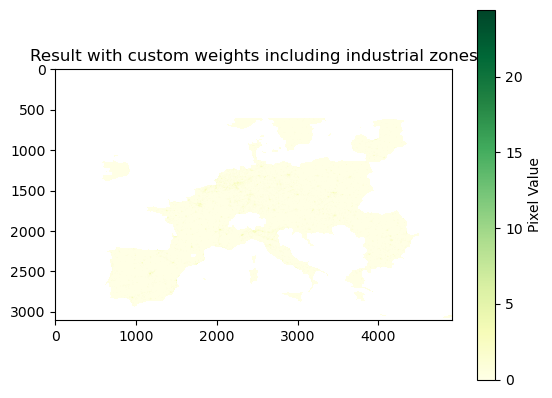

In [7]:
                        # Protected nature,   water bodies     &  industrial zones  
raster_exclude = merge * masked_arrays[10] * masked_arrays[11] * masked_arrays[12]

plt.imshow(raster_exclude, cmap='YlGn')
plt.colorbar(label='Pixel Value')
plt.title('Result with custom weights including industrial zones')
plt.show()

output_file = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/result_custom_weights_industrial_zoning.tif'

# Get metadata from one of the input raster files (assuming all have the same metadata)
with rasterio.open('C:/Users/michi/Documents/Blok 2 Jaar 4/Datasets_final_aligned/population_align4.tif') as src:
    profile = src.profile

# Update metadata if necessary 
profile.update(
    dtype=rasterio.float64,  
    count=1,  
    compress='lzw',  #
    nodata=-3.40282347e+38,  
)

# Create a new raster file for writing
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(raster_exclude.filled(), 1)

,placeholder,geometry
0,centerpoint,POINT (5.49920 46.02103)


,placeholder,geometry
0,centerpoint,"POLYGON ((793443.235 5099421.042, 792961.708 5..."


<AxesSubplot:>

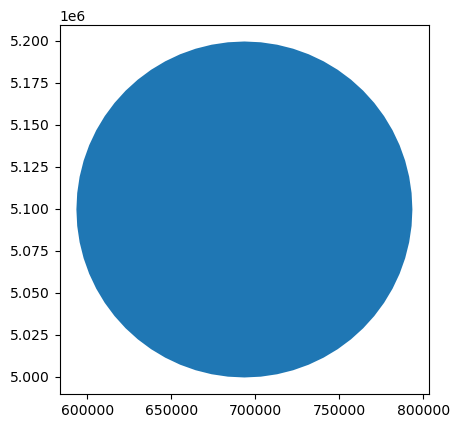

In [15]:
from shapely.geometry import Point
d = {'placeholder': ['centerpoint'], 'geometry': [Point(new_warehouse['Longitude'], new_warehouse['Latitude'])]}
type(d)
singlepoint = gpd.GeoDataFrame(d, crs="EPSG:4326")
display(singlepoint)
singlepoint = singlepoint.to_crs(3043) 
singlepoint['geometry'] = singlepoint['geometry'].buffer(100000)
display(singlepoint)  
singlepoint.plot()

In [11]:
singlepoint = singlepoint.to_crs(epsg=4326)
m = folium.Map(location=[46.021031, 5.499198], zoom_start=7, height=500)
folium.GeoJson(singlepoint).add_to(m)
m.save("map_with_buffer.html")
m

In [10]:
from rasterio.mask import mask
outRas = 'C:/Users/michi/Documents/Blok 2 Jaar 4/Final_datasets/clippedrasters.tif'

with rasterio.open(output_file) as src:
    singlepoint=singlepoint.to_crs(src.crs)
    out_image, out_transform=mask(src,singlepoint.geometry,crop=True)
    out_image[out_image >= 20] = 0
    out_image[out_image==0] = np.nan
    out_meta=src.meta.copy()
    
out_meta.update({
    "driver":"Gtiff",
    "height":out_image.shape[1], 
    "width":out_image.shape[2], 
    "transform":out_transform
})
              
with rasterio.open(outRas,'w',**out_meta) as dst:
    dst.write(out_image)